This notebook generates tables and graphs to compare ensemble pairs

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import json
from itertools import combinations

from knobs_functions import *

In [9]:
state = 'FL' 
chamber = 'congress'
my_ensemble_list = ['distpair_ust', 'distpair', 'ust', 'base0', 'county25', 'county50', 'county75', 'county100']

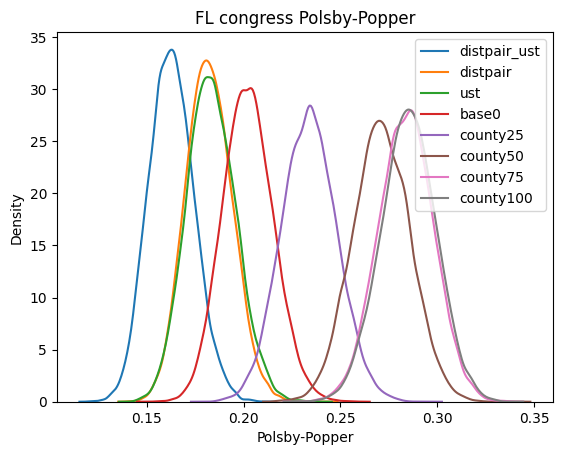

In [10]:
kde_plot(state, chamber, my_ensemble_list, 'Polsby-Popper', average_lines=False)

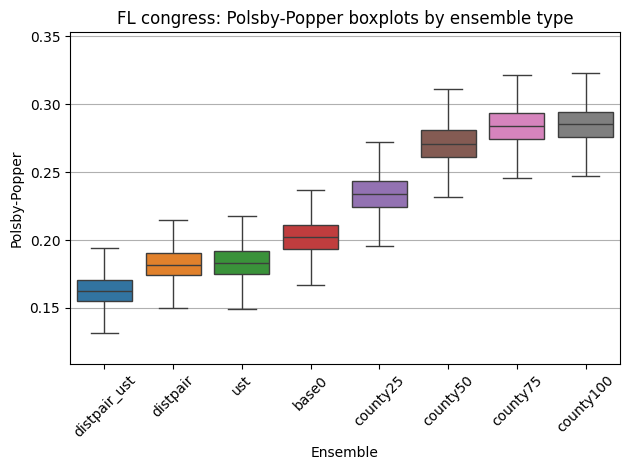

In [11]:
box_whisker_plot(state, chamber, my_ensemble_list, "Polsby-Popper")

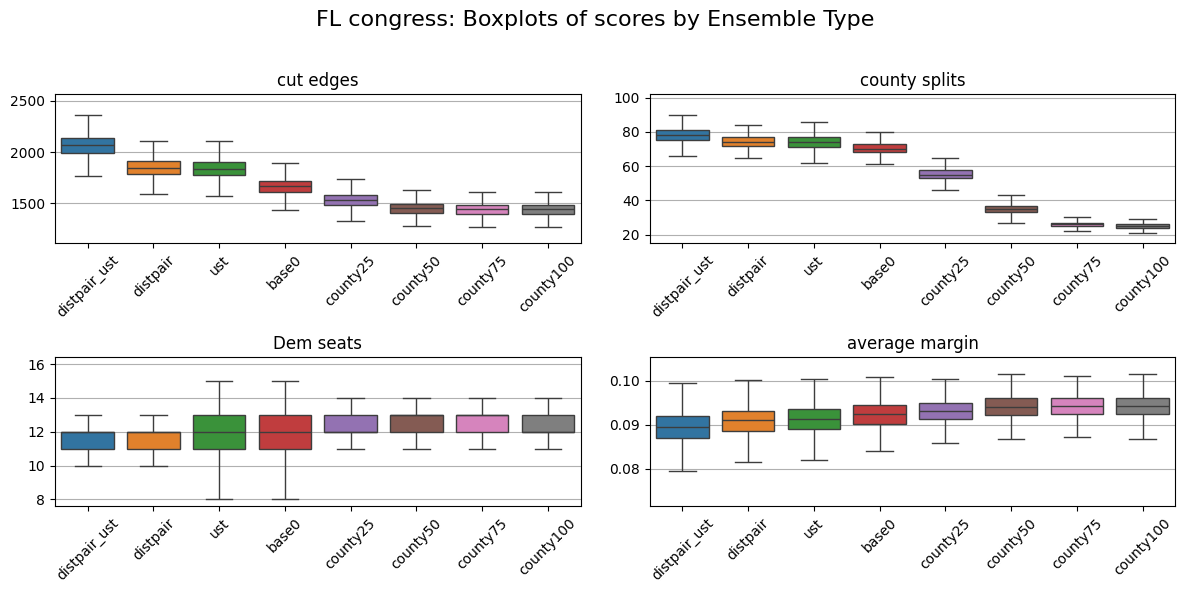

In [7]:
my_score_list = ['cut edges', 'county splits', 'Dem seats', 'average margin']
box_whisker_plots_grid(state, chamber, my_ensemble_list, my_score_list, filename='box_whisker_plot_grid.png', cols=2)

In [12]:
# make dictionaries from which later dataframes will be created.
# Each dictionary will map (state, chamber, ensemble, score) to a specific measurement of closeness to the base0 ensemble.

mean_diff_dict = {}
KS_stat_dict = {}
KS_pvalue_dict = {}
T_pvalue_dict = {}

for state, chamber in state_chamber_list:
    for score in primary_score_list:
        a0 = fetch_score_array(state, chamber, 'base0', score)
        for ensemble in ['base1', 'base2', 'base3', 'base4'] + ensemble_list:
            a1 = fetch_score_array(state, chamber, ensemble, score)
            mean_diff = np.mean(a1) - np.mean(a0)
            KS_stat, KS_pvalue, KS_sign = ks_test(a0, a1)
            KS_signed_stat = KS_stat * KS_sign
            _, T_pvalue = t_test(a1, a0)

            mean_diff_dict[(state, chamber, ensemble, score)] = mean_diff
            KS_stat_dict[(state, chamber, ensemble, score)] = KS_signed_stat
            KS_pvalue_dict[(state, chamber, ensemble, score)] = KS_pvalue
            T_pvalue_dict[(state, chamber, ensemble, score)] = T_pvalue

Let's measure the mean-difference between scores

In [24]:
def mean_diff_table(score, my_ensemble_list = ['base1']+ ensemble_list, pvalue = None, latex_filename = None, rounding = 2):
    """
    Returns a dataframe showing (for each state-chamber pair and each ensemble type)
    the mean-difference between that ensemble and the base0 ensemble with respect to the given score.
    If pvalue is set, it will mark values that are significantly different from the base0 ensemble.
    if latex_filename is set, it will also save the dataframe as a latex table.

    Args:
        score: use any valid score, or use 'Dem share' for 'Dem seats' divided by the number of seats.
        p_value: set to None if you don't want marks.
    """

    index_list = [f'{a[0]} {a[1]}' for a in state_chamber_list] + ['AVERAGE']
    df = pd.DataFrame(columns = my_ensemble_list, index = index_list)
    df_mark = df.copy() # True/False signifying whether the value is marked as statistically significant

    effective_score = 'Dem seats' if score == 'Dem share' else score
    for state, chamber in state_chamber_list:
        denom = num_seats_dict[(state, chamber)] if score == 'Dem share' else 1
        for ensemble in my_ensemble_list:
            mean_diff = mean_diff_dict[(state, chamber, ensemble, effective_score)] / denom
            mean_diff = np.round(mean_diff, 2)
            p_value = T_pvalue_dict[(state, chamber, ensemble, effective_score)]
            df.loc[f'{state} {chamber}', ensemble] = mean_diff
            df_mark.loc[f'{state} {chamber}', ensemble] = (pvalue != None and p_value < pvalue)
    df.loc['AVERAGE'] = df.mean().round(rounding)
    df = df.round(rounding) 
    df_latex = df.copy()

    # combine the values and markings into dataframes to return and for Latex
    state_chamber_size_dict = {f'{state} {chamber}': f'{state} {num_seats_dict[(state, chamber)]}' 
                           for state, chamber in state_chamber_list}
    for state, chamber in state_chamber_list:
        for ensemble in my_ensemble_list:
            if df_mark.loc[f'{state} {chamber}', ensemble]:
                df_latex.loc[f'{state} {chamber}', ensemble] = f'\\textbf{{{df.loc[f"{state} {chamber}", ensemble]}}}'
                df.loc[f'{state} {chamber}', ensemble] = f'*{df.loc[f"{state} {chamber}", ensemble]}'

    if latex_filename is not None:
        df_latex.rename(columns=ensemble_name_dict, index=state_chamber_size_dict, inplace=True)
        df_latex.to_latex(latex_filename, escape=False)
    return df

In [25]:
my_ensemble_list = ['base1'] + [x for x in ensemble_list if x != 'reversible']

In [27]:
ds = mean_diff_table('Dem seats', my_ensemble_list, pvalue=.001, latex_filename='latex tables/mean_diff_table.tex')
ds

C:\Users\ktapp\AppData\Local\Temp\ipykernel_33920\727504878.py:41: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_latex.to_latex(latex_filename, escape=False)


,base1,pop_minus,pop_plus,distpair,ust,distpair_ust,county25,county50,county75,county100
FL congress,0.0,0.01,0.0,*-0.18,*-0.11,*-0.29,*0.42,*0.59,*0.56,*0.55
FL upper,0.02,-0.01,0.02,*-0.09,-0.02,*-0.14,*0.07,0.04,*0.05,*0.1
FL lower,0.01,0.03,0.03,0.01,-0.0,-0.06,*-0.12,*-0.21,*-0.09,*0.07
IL congress,0.0,-0.01,-0.0,*0.03,0.01,*0.04,*-0.06,*-0.23,*-0.23,*-0.21
IL upper,-0.01,-0.03,0.04,-0.01,*0.1,*0.09,-0.03,0.0,*-0.07,*-0.15
IL lower,0.01,0.03,0.0,-0.05,*0.08,0.01,*-0.14,*-0.14,*-0.22,*-0.35
MI congress,-0.0,0.0,0.0,*0.05,*0.06,*0.09,*-0.04,*-0.16,*-0.26,*-0.27
MI upper,-0.01,-0.0,-0.03,*0.07,0.03,*0.18,0.01,*0.11,*0.13,*0.14
MI lower,-0.03,-0.02,0.01,0.03,-0.06,0.04,*0.23,*0.46,*0.53,*0.48
NC congress,0.01,0.01,-0.0,*-0.03,*-0.05,*-0.08,*-0.04,*-0.07,*-0.08,*-0.09


In [28]:
ds2 = mean_diff_table('competitive districts', my_ensemble_list, pvalue=.001, latex_filename='latex tables/competitive_table.tex')
ds2

C:\Users\ktapp\AppData\Local\Temp\ipykernel_33920\727504878.py:41: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_latex.to_latex(latex_filename, escape=False)


,base1,pop_minus,pop_plus,distpair,ust,distpair_ust,county25,county50,county75,county100
FL congress,-0.02,-0.04,-0.01,*0.46,*0.3,*0.88,-0.03,*-0.09,*-0.11,*-0.1
FL upper,-0.02,-0.02,*-0.06,0.03,0.05,*0.16,*-0.14,*-0.31,*-0.37,*-0.43
FL lower,0.05,0.09,-0.0,*0.11,*0.14,*0.19,*0.45,*0.39,*0.28,*0.44
IL congress,-0.0,-0.02,-0.01,*0.04,0.02,*0.06,*-0.16,0.01,*0.06,*0.05
IL upper,-0.04,*-0.12,*0.1,*0.08,*0.07,*0.21,*-0.07,*0.13,*0.26,*0.37
IL lower,0.0,-0.02,0.05,*0.25,*0.1,*0.34,*0.23,*0.78,*1.43,*1.65
MI congress,0.0,-0.01,-0.0,*-0.07,*-0.06,*-0.15,0.01,*0.07,*0.12,*0.1
MI upper,-0.02,0.03,-0.04,*0.35,0.01,*0.43,*-0.1,*-0.08,*-0.07,-0.06
MI lower,0.02,-0.02,-0.03,-0.08,-0.07,-0.08,*0.34,*0.63,*0.76,*0.76
NC congress,-0.01,0.0,0.01,-0.01,*0.05,0.04,0.0,*-0.08,*-0.14,*-0.16


Now let's measure how close the ordered-seats-plots are to the base ensemble.

In [29]:
# Add more dictionaries corresponding to the distance between orderd-seats plots.
# Each dictionary will map (state, chamber, ensemble) to a measurement of closeness to the base0 ensemble.
# The measurement is the (max/mean) over the ordered seats of the ks-distance for that seat between the base0 ensemble and the ensemble in question. 
# We consider ALL ordered seats or just the COMPEITIVE ones.

OSP_all_max = {}
OSP_all_mean = {}
OSP_competitive_max = {}
OPS_competitive_mean = {}
OSP_num_competitive = {}

for state, chamber in state_chamber_list:
    X0 = fetch_score_array(state, chamber, 'base0', 'by_district')
    for ensemble in ['base1', 'base2', 'base3', 'base4'] + ensemble_list:
        X1 = fetch_score_array(state, chamber, ensemble, 'by_district')
        num_seats = X0.shape[1]
        ls = []
        ls_comp = []
        for i in range(num_seats):
            closeness = ks_test(X1[:, i], X0[:, i])[0]
            ls.append(closeness)
            if abs(np.mean(X0[:, i]) - 0.5) < .05 or abs(np.mean(X1[:, i]) - 0.5) < .05:
                ls_comp.append(closeness)
        OSP_all_max[(state, chamber, ensemble)] = np.max(ls)
        OSP_all_mean[(state, chamber, ensemble)] = np.mean(ls)
        OSP_competitive_max[(state, chamber, ensemble)] = np.max(ls_comp)
        OPS_competitive_mean[(state, chamber, ensemble)] = np.mean(ls_comp)
        OSP_num_competitive[(state, chamber, ensemble)] = len(ls_comp)

In [32]:
def Ordered_seats_table(my_ensemble_list = ['base1']+ ensemble_list, combine_method = 'max', seats = 'competitive', rounding = 2, latex_filename = None):
    """
    Returns a dataframe showing (for each state-chamber pair and each ensemble type) 
    the "distance" between the ordered seats plots of the ensemble and the base0 ensemble.
    It sums or averages the ks-distance between the ordered seats.
    If seats == 'competitive', it only considers seats that are competitive for at least one of the two ensembles being compared.
    """
    index_list = [f'{a[0]} {a[1]}' for a in state_chamber_list] + ['AVERAGE']
    df = pd.DataFrame(columns = my_ensemble_list, index = index_list)
    for state, chamber in state_chamber_list:
        for ensemble in my_ensemble_list:
            if seats == 'all':
                if combine_method == 'max':
                    closeness = OSP_all_max[(state, chamber, ensemble)]
                elif combine_method == 'mean':
                    closeness = OSP_all_mean[(state, chamber, ensemble)]
            elif seats == 'competitive':
                if combine_method == 'max':
                    closeness = OSP_competitive_max[(state, chamber, ensemble)]
                elif combine_method == 'mean':
                    closeness = OPS_competitive_mean[(state, chamber, ensemble)]
            df.loc[f'{state} {chamber}', ensemble] = closeness
    df = df.apply(pd.to_numeric)
    df.loc['AVERAGE'] = df.iloc[:-1].mean()
    df = df.round(rounding)

    if latex_filename is not None:
        state_chamber_size_dict = {f'{state} {chamber}': f'{state} {num_seats_dict[(state, chamber)]}' 
                           for state, chamber in state_chamber_list}
        df_latex = df.copy()
        df_latex.rename(columns=ensemble_name_dict, index = state_chamber_size_dict, inplace=True)
        df_latex.to_latex(latex_filename, escape=False)
    return df

In [33]:
Ordered_seats_table(my_ensemble_list, 'max', 'competitive', latex_filename='latex tables/OSP.tex')

C:\Users\ktapp\AppData\Local\Temp\ipykernel_33920\3337259921.py:32: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_latex.to_latex(latex_filename, escape=False)


,base1,pop_minus,pop_plus,distpair,ust,distpair_ust,county25,county50,county75,county100
FL congress,0.02,0.02,0.02,0.13,0.09,0.24,0.18,0.30,0.30,0.29
FL upper,0.02,0.04,0.07,0.04,0.02,0.07,0.06,0.11,0.13,0.16
FL lower,0.01,0.03,0.01,0.03,0.03,0.05,0.07,0.09,0.09,0.09
IL congress,0.01,0.01,0.01,0.04,0.07,0.06,0.09,0.21,0.25,0.25
IL upper,0.01,0.02,0.03,0.03,0.04,0.07,0.05,0.13,0.17,0.20
IL lower,0.01,0.02,0.02,0.03,0.04,0.07,0.04,0.13,0.22,0.26
MI congress,0.01,0.01,0.01,0.07,0.09,0.15,0.04,0.15,0.21,0.22
MI upper,0.01,0.03,0.05,0.08,0.02,0.14,0.04,0.10,0.13,0.14
MI lower,0.01,0.02,0.02,0.04,0.02,0.04,0.08,0.19,0.25,0.26
NC congress,0.01,0.01,0.03,0.03,0.03,0.07,0.03,0.08,0.12,0.12


In [ ]:
# Here is a slower but more flexible version that works with an arbitrary competitive window.
def Ordered_seats_table(competitive_window = .05, metric = 'mean_diff', combine_method = 'max',
                          plot_threshold = None):
    """
    Returns a dataframe showing (for each state-chamber pair and each ensemble type) 
    the "distance" between the ordered seats plots of the ensemble and the base0 ensemble.
    It only considers seats that are competitive for at least one of the two ensembles being compared,
    (which means that dem share is within competitive_window of 0.5 for at least one of the two ensembles).
    Args:
        competitive_window: the window around 0.5 that defines a competitive seat (default .05)
        metric: 'mean_diff' or 'ks' to measure, for each seat, the distance between the two histograms 
        combine_method: 'max', 'mean', 'sum' (default 'max')
        plot_threshold: if not None, it plots an ordered-seats plot for each cell of the returned dataframe past the threshold.
    """
    index_list = [f'{a[0]} {a[1]}' for a in state_chamber_list] + ['AVERAGE']
    columns_list = ['base1']+ ensemble_list
    df = pd.DataFrame(columns = columns_list, index = index_list)
    for state, chamber in state_chamber_list:
        for ensemble in columns_list:
            X0 = fetch_score_array(state, chamber, 'base0', 'by_district')
            X1 = fetch_score_array(state, chamber, ensemble, 'by_district')
            num_seats = X0.shape[1]
            ls = []
            for i in range(num_seats):
                if abs(np.mean(X0[:, i]) - 0.5) < competitive_window or abs(np.mean(X1[:, i]) - 0.5) < competitive_window:
                    if metric == 'mean_diff':
                        closeness = abs(np.mean(X1[:, i]) - np.mean(X0[:, i]))
                    elif metric == 'ks':
                        closeness, _, __ = ks_test(X1[:, i], X0[:, i])
                    else:
                        raise ValueError('metric must be mean_diff or ks')
                    ls.append(closeness)
            if combine_method == 'sum':
                combined_closeness = sum(ls)
            elif combine_method == 'mean':
                combined_closeness = np.mean(ls)
            elif combine_method == 'max':
                combined_closeness = max(ls)
            else:
                raise ValueError('combine_method must be sum, mean or max')

            df.loc[f'{state} {chamber}', ensemble] = combined_closeness
            if plot_threshold is not None and combined_closeness > plot_threshold:
                box_plot(state, chamber, [ensemble, 'base0'], competitive_window=competitive_window)
    df = df.apply(pd.to_numeric)
    return df

Let's create tables showing how consistent and significant the differences are over the state-chamber pairs.

In [6]:
def significance_table(my_score_list = primary_score_list, my_ensemble_list= ensemble_list, my_state_chamber_list=state_chamber_list,
               based_on = 'ks_p', threshold = .001, display_extremes = True, transpose = True):
    """
    Create a dataframe whose columns are the scores and whose rows are the ensembles.
    Each cell contains a string of +, -, or 0, one for each state-chamber, to compare that ensemble's score to that of the base0 ensemble.
    if based_on == 'ks', the symbol indicates whether the KS statistic is above the threshold.
    if based_on == 'ks_p', it indicates whether the KS pvalue is below the threshold.
    if based_on == 't_p', it indicates whether the t-test pvalue is below the threshold.
    if display_extremes is True, the cell will also contain a dictionary with the state-chamber with 
    the largest and smallest KS-statistic (or mean-difference statistics if based_on='t_p').

    It returns the transpose if transpose is True.
    """
    df = pd.DataFrame(columns=my_score_list, index=my_ensemble_list).fillna('')
    for score in my_score_list:
        for ensemble in my_ensemble_list:
            string_of_symbols = ''
            min_stat = 0
            max_stat = 0
            max_state_chamber = ''
            min_state_chamber = ''
            for state, chamber in my_state_chamber_list:
                md = mean_diff_dict[state, chamber, ensemble, score]
                ks = KS_stat_dict[state, chamber, ensemble, score]
                ks_p = KS_pvalue_dict[state, chamber, ensemble, score]
                t_p = T_pvalue_dict[state, chamber, ensemble, score]

                if based_on == 'ks':
                    if np.abs(ks) > threshold:
                        x = '+' if ks > 0 else '-'
                    else:
                        x = '0'
                if based_on == 't_p':
                    if t_p < threshold:
                        x = '+' if md > 0 else '-'
                    else:
                        x = '0'
                elif based_on == 'ks_p':
                    if ks_p < threshold:
                        x = '+' if ks > 0 else '-'
                    else:
                        x = '0'
                string_of_symbols += x
                
                if x in ['+', '-']:
                    stat = ks if based_on in ['ks', 'ks_p'] else md
                    if stat > max_stat:
                        max_stat = stat
                        max_state_chamber = f'{state}_{chamber}'
                    if stat < min_stat:
                        min_stat = stat
                        min_state_chamber = f'{state}_{chamber}'

            if display_extremes:
                D = dict()
                if max_stat > 0:
                    D[max_state_chamber] = np.round(max_stat,3)
                if min_stat < 0:
                    D[min_state_chamber] = np.round(min_stat,3)
                if len(D) > 0:
                    df.at[ensemble, score] = f'{string_of_symbols}{D}'
                else:
                    df.at[ensemble, score] = string_of_symbols
            else:
                df.at[ensemble, score] = string_of_symbols

    if transpose:
        df = df.transpose()
    return df

In [8]:
# test that the other 4 base ensembles are all close to base0
test = significance_table(my_ensemble_list=['base1', 'base2', 'base3', 'base4'],
                    based_on = 'ks_p', threshold = .001, display_extremes=False)
test

,base1,base2,base3,base4
Reock,000000000000000000000,000000000000000000000,000000000000000000000,00-000000000000000000
Polsby-Popper,000000000000000000000,000000000000000000000,000000000000000000000,000000000000000000000
cut edges,000000000000000000000,000000000000000000000,000000000000000000000,000000000000000000000
Dem seats,000000000000000000000,000000000000000000000,000000000000000000000,000000000000000000000
efficiency gap,000000000000000000000,000000000000000000000,000000000000000000000,000000000000000000000
mean-median,000000000000000000000,000000000000000000000,000000000000000000000,000000000000000000000
partisan bias,000000000000000000000,000000000000000000000,000000000000000000000,000000000000000000000
competitive districts,000000000000000000000,000000000000000000000,000000000000000000000,000000000000000000000
average margin,000000000000000000000,000000000000000000000,000000000000000000000,000000000000000000000
MMD black,000000000000000000000,000000000000000000000,000000000000000000000,000000000000000000000


In [ ]:
compact_score_list = ['Reock', 'Polsby-Popper', 'cut edges']
partisan_score_list = ['Dem seats', 'efficiency gap', 'mean-median', 'partisan bias', 'competitive districts', 'average margin']
MMD_score_list = ['MMD black', 'MMD hispanic', 'MMD coalition']
county_score_list = ['county splits', 'counties split']

base_ensemble_list = ['base1', 'base2', 'base3', 'base4']
ensemble_list = ['pop_minus', 'pop_plus', 'distpair', 'ust',  'distpair_ust', 'reversible', 
                'county25', 'county50', 'county75', 'county100']
county_ensemble_list = ['county25', 'county50', 'county75', 'county100']
pop_ensemble_list = ['pop_minus', 'pop_plus']
recom_ensemble_list = ['distpair', 'ust', 'distpair_ust', 'reversible']

In [13]:
# use threshold = 1 to remove the 0 option (for checking consistency over the state-chamber pairs)
T = significance_table(my_ensemble_list=pop_ensemble_list, based_on='t_p', threshold=1, display_extremes=False)
T

,pop_minus,pop_plus
Reock,-+-++++-+-+++++++++++,-+++---+----------+--
Polsby-Popper,+-----+--------++-+--,+++++++++-++++++++-++
cut edges,++++++-++++++++-++-++,------------------+--
Dem seats,+-+--++--+++++++++--+,+++-+++-+---++-++--+-
efficiency gap,-+-++--++--+------+--,---+---+-+-+--+--++-+
mean-median,++--+++++---+++-+-+--,-+++-+++-----+---+-+-
partisan bias,-+++----++------+-++-,-+-----++-+++++--++--
competitive districts,--+----+-+++++---++-+,----++---+-+-++-+----
average margin,+--+-+++++-+--+++--+-,-++-++---++++--+-+-++
MMD black,+--------0+++--0++0--,0++-++--+0+++--0++0+-


In [14]:
T = significance_table(my_ensemble_list=recom_ensemble_list, based_on='t_p', threshold=1, display_extremes=False)
T

,distpair,ust,distpair_ust,reversible
Reock,---------------------,---------------------,---------------------,---------------------
Polsby-Popper,---------------------,---------------------,---------------------,---------------------
cut edges,+++++++++++++++++++++,+++++++++++++++++++++,+++++++++++++++++++++,+++++++++++++++++++++
Dem seats,--++--+++-+-+++---+--,---+++++--+-+++---+--,---++++++-+-+++---+--,--+-+-++++++--++-+++-
efficiency gap,++--+----+-+---+++-++,+++-----++-+-+-+++-++,+++------+-+---+++-++,++-+-+------++--+---+
mean-median,++++++---+---+-+---+-,++++-+--++---+-+---+-,-+++++---+---+-+---+-,++-+-+--+--+-+-+++-++
partisan bias,+++-++---------+----+,++-------+-+---+----+,+++-++---+-----+---++,++---+--+---+--++---+
competitive districts,++++++-+--+++++-+-+-+,++++++-+-+++-++-+-+-+,++++++-+-+++-++-+-+-+,+-++-+-+--+--++---+-+
average margin,---------------------,---+--------+--------,---------------------,-+----+--+--+--+---++
MMD black,++-------0-----0--0+-,0--------0-----0--0+-,++-------0-----0--0+-,0+---+++-0-+-+-0--0++


In [16]:
T = significance_table(my_ensemble_list=county_ensemble_list, based_on='t_p', threshold=1, display_extremes=False)
T

,county25,county50,county75,county100
Reock,+++++++++++++++-++-++,+++++++++++++++++++++,+++++++++++++++++++++,+++++++++++++++++++++
Polsby-Popper,+++++++++++++++++++++,+++++++++++++++++++++,+++++++++++++++++++++,+++++++++++++++++++++
cut edges,---------------------,---------------------,---------------------,---------------------
Dem seats,++-----++-++-+-+-+-++,++--+--++-++-+------+,++-----++-++-++--+--+,+++----++-++-++--+--+
efficiency gap,--+++++--+--+---+-++-,--++-++--+--+---+-++-,--+++++--+--+---+-++-,---++++--+--+---+-++-
mean-median,-+--++++-+--++-++-+-+,---++++--+--+++++-+-+,---++++--+--+++++-+-+,---++++--+--+++++-+-+
partisan bias,---+-++--+-----++-+++,--++-++--+-----++-+++,--++-++--+-----++-+++,----+++--+-----++-+++
competitive districts,--+--++-++-+-----+-+-,--+++++-+----+---+-+-,--+++++-+----+---+-+-,--+++++-+----+---+-+-
average margin,+++-++++-++++++++++++,+++++++++++++++++++++,+++++-+++++++++++++++,+++++-+++++++++++++++
MMD black,+--++++--0+++++0--0++,0+-++++--0+++++0+-0++,++-++++--0+++++0+-0++,+--++++--0+++++0+-0++


In [28]:
T = significance_table(my_ensemble_list=ensemble_list, based_on='t_p', threshold=1, display_extremes=False)
T

,pop_minus,pop_plus,distpair,ust,distpair_ust,reversible,county25,county50,county75,county100
Reock,-+-++++-+-+++++++++++,-+++---+----------+--,---------------------,---------------------,---------------------,---------------------,+++++++++++++++-++-++,+++++++++++++++++++++,+++++++++++++++++++++,+++++++++++++++++++++
Polsby-Popper,+-----+--------++-+--,+++++++++-++++++++-++,---------------------,---------------------,---------------------,---------------------,+++++++++++++++++++++,+++++++++++++++++++++,+++++++++++++++++++++,+++++++++++++++++++++
cut edges,++++++-++++++++-++-++,------------------+--,+++++++++++++++++++++,+++++++++++++++++++++,+++++++++++++++++++++,+++++++++++++++++++++,---------------------,---------------------,---------------------,---------------------
Dem seats,+-+--++--+++++++++--+,+++-+++-+---++-++--+-,--++--+++-+-+++---+--,---+++++--+-+++---+--,---++++++-+-+++---+--,--+-+-++++++--++-+++-,++-----++-++-+-+-+-++,++--+--++-++-+------+,++-----++-++-++--+--+,+++----++-++-++--+--+
efficiency gap,-+-++--++--+------+--,---+---+-+-+--+--++-+,++--+----+-+---+++-++,+++-----++-+-+-+++-++,+++------+-+---+++-++,++-+-+------++--+---+,--+++++--+--+---+-++-,--++-++--+--+---+-++-,--+++++--+--+---+-++-,---++++--+--+---+-++-
mean-median,++--+++++---+++-+-+--,-+++-+++-----+---+-+-,++++++---+---+-+---+-,++++-+--++---+-+---+-,-+++++---+---+-+---+-,++-+-+--+--+-+-+++-++,-+--++++-+--++-++-+-+,---++++--+--+++++-+-+,---++++--+--+++++-+-+,---++++--+--+++++-+-+
partisan bias,-+++----++------+-++-,-+-----++-+++++--++--,+++-++---------+----+,++-------+-+---+----+,+++-++---+-----+---++,++---+--+---+--++---+,---+-++--+-----++-+++,--++-++--+-----++-+++,--++-++--+-----++-+++,----+++--+-----++-+++
competitive districts,--+----+-+++++---++-+,----++---+-+-++-+----,++++++-+--+++++-+-+-+,++++++-+-+++-++-+-+-+,++++++-+-+++-++-+-+-+,+-++-+-+--+--++---+-+,--+--++-++-+-----+-+-,--+++++-+----+---+-+-,--+++++-+----+---+-+-,--+++++-+----+---+-+-
average margin,+--+-+++++-+--+++--+-,-++-++---++++--+-+-++,---------------------,---+--------+--------,---------------------,-+----+--+--+--+---++,+++-++++-++++++++++++,+++++++++++++++++++++,+++++-+++++++++++++++,+++++-+++++++++++++++
MMD black,+--------0+++--0++0--,0++-++--+0+++--0++0+-,++-------0-----0--0+-,0--------0-----0--0+-,++-------0-----0--0+-,0+---+++-0-+-+-0--0++,+--++++--0+++++0--0++,0+-++++--0+++++0+-0++,++-++++--0+++++0+-0++,+--++++--0+++++0+-0++


In [29]:
T.to_csv('sign_table.csv')

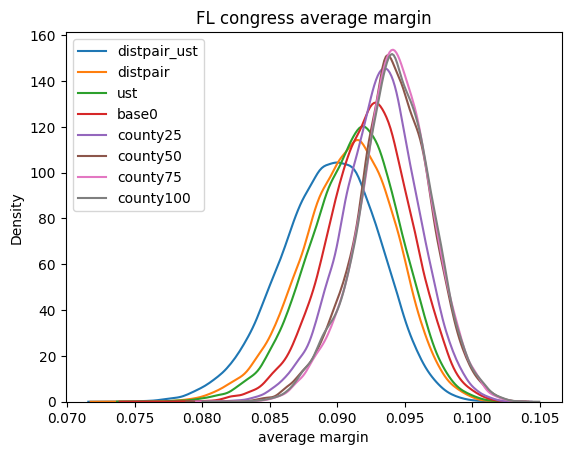

In [30]:
state = 'FL' 
chamber = 'congress'
score = 'average margin'
my_ensemble_list = ['distpair_ust', 'distpair', 'ust', 'base0', 'county25', 'county50', 'county75', 'county100']
kde_plot(state, chamber, my_ensemble_list, score, average_lines=False, filename='graphs/FL_cong_avg_margin_kde_plot.png')

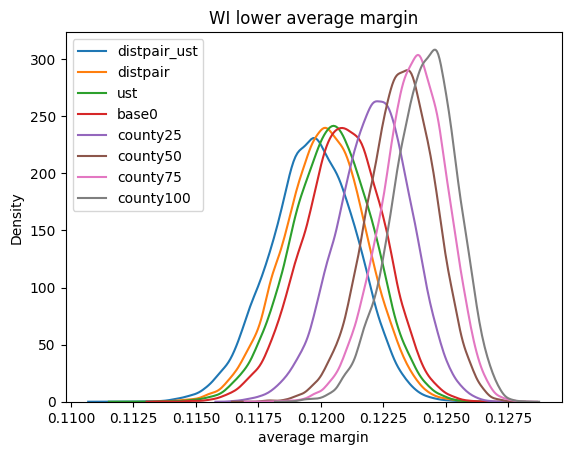

In [22]:
state = 'WI' 
chamber = 'lower'
score = 'average margin'
my_ensemble_list = ['distpair_ust', 'distpair', 'ust', 'base0', 'county25', 'county50', 'county75', 'county100']
kde_plot(state, chamber, my_ensemble_list, score, average_lines=False, filename='graphs/WI_lower_avg_margin_kde_plot.png')

In [ ]:
# check whether they stack up in the same order for the other state-chamber combos
score = 'average margin'
my_ensemble_list = ['distpair_ust', 'ust', 'base0', 'county25', 'county25', 'county75']
for state, chamber in state_chamber_list:
    kde_plot(state, chamber, my_ensemble_list, score, average_lines=True, filename=f'graphs/{state}_{chamber}_avg_margin.png')

In [ ]:
# print the order of the averages of the above histograms
score = 'average margin'
my_ensemble_list = ['distpair_ust', 'ust', 'base0', 'county25', 'county25', 'county75']
for state, chamber in state_chamber_list:
    mean_dict = dict()
    for ensemble in ensemble_list:
        a = fetch_score_array(state, chamber, ensemble, score)
        mean_dict[ensemble] = np.mean(a)
    l = sorted(mean_dict,key=mean_dict.get)
    print(f'{state}, {chamber}: {l}')